# Recovering Solutions of Grover's Algorithm with an Imprecise Oracle
## James Saslow
## 9/27/2023

In [1]:
# Importing packages
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, transpile
S_simulator = Aer.backends(name='statevector_simulator')[0]

In [2]:
# Custom Grovers algorithm functions

def GroverIters(num_qubits):
    return int(np.pi/4 * np.sqrt(2**num_qubits)) 
    
    
def EpsFunc(theta,prob, percentage):
    eps = abs(np.pi - theta[np.argmin((prob - percentage)**2)])
    return eps
    
    
def Grovers(num_qubits, theta, **kwargs):
    '''
    ***Code Documentation***
    
    Function Parameters:
    num_qubits = qubit size of quantum circuit
    theta      = phase of oracle operation (theta = pi for standard Grover's)
    
    Kwargs:
    iters : iters = # for custom number of grover iterations
    '''
    
    # ================= Initializing Parameters ===========================
    
    num_bases = 2**num_qubits                         # Number of basis states
    t_grovers = int(np.pi/4 * np.sqrt(2**num_qubits)) # Recommended Number of iterations
    
    # Unless number of iterations is specified, default to suggested grover iterations
    if 'iters' in kwargs:
        iters = int(kwargs['iters'])
    else:
        iters = t_grovers
    
    # ================= Quantum Algorithm ================================= 
    
    # Determining window scanning size of theta
    if type(theta) == float or int:
        N_scan = 1
    if type(theta) == np.ndarray:
        N_scan = len(theta)
        
    # An array where we will record final marked state complex amplitudes
    marked_states = np.ones(N_scan, dtype = complex)
    
    for k in range(N_scan):
        
        # Equal Superposition State
        a_M = 1/np.sqrt(num_bases) # Marked State Amplitude (There is x1 of these)
        a_N = 1/np.sqrt(num_bases) # Non-marked State Amplitude (There are x(num_bases - 1) of these)

        for i in range(iters):
            # ======== Grovers Algorithm ============

            # Oracle Operation
            if N_scan == 1: # If a single theta value
                a_M *= np.exp(1j * theta) # Do Oracle Operation
            else: # If an array of theta values
                a_M *= np.exp(1j * theta[k]) # Do Oracle Operation
                
            # Calculating the mean point
            alpha_bar = (a_N*(num_bases-1) + a_M)/num_bases # Average Amplitude

            # Diffusion Operation
            a_M = 2*alpha_bar - a_M # Updating Marked state amplitude
            a_N = 2*alpha_bar - a_N # Updating Non-marked state amplitudes
            
        # Recording each marked state amplitude after 'iters' number of iterations for each theta value
        marked_states[k] = a_M
    
    # ================= Results ================================= 
    
    # Returning final marked amplitude
    if N_scan == 1:
        return marked_states[0]
    else:
        return marked_states
    return marked_states

In [3]:
# Custom Qiskit Function that reiurn the wavefunction psi with basis vectors in ascending binary order

def ReturnPsi(obj, **kwargs):
    '''
    Returns the wavefunction psi in a numpy array
    '''
    if(type(obj) == QuantumCircuit  ):
        statevec = execute( obj, S_simulator, shots=1 ).result().get_statevector()
    if(type(obj) == np.ndarray):
        statevec = obj
    statevec = list( np.asarray(statevec) )
    #==========================================
    dec = 5
    if 'precision' in kwargs:
        dec = int( kwargs['precision'] )
           
    # Rounding off states
    statevec = np.round(statevec,dec) 
    num_bases = len(statevec)
    num_qubits = int(np.log2(num_bases))
    
    
    def bin_gen(number, num_qubits):
        bin1 = bin(number)[2:]
        L = num_qubits - len(bin1)
        bin2 = L*'0' + bin1
        return bin2
    
    def rev_bin_gen(number, num_qubits):
        return bin_gen(number, num_qubits)[::-1]
    
    def binto10(number):
        num_qubits = len(number)
        num_bases  = int(2**num_qubits)
        reg_order = []
        for i in range(num_bases):
            reg_order.append(bin_gen(i, num_qubits))
            
        reg_order = np.array(reg_order)
        return np.where(reg_order == number)[0][0]
    
    def dual_sort(key, values):
        k=1
        while k!=0:
            k=0
            for i in range(len(key)-1):
                a = key[i]
                b = key[i+1]

                c = values[i]
                d = values[i+1]

                if b<a:
                    k+=1
                    key[i] = b
                    key[i+1] = a

                    values[i] = d
                    values[i+1] = c
                       
        return values

    key = []
    for i in range(num_bases):
        key.append(binto10(rev_bin_gen(i, num_qubits)))
        
    psi = dual_sort(key, statevec)
    
    return psi
    
    
# Making a function that converts base 10 to base 2 and uses braket notation
def base10to2(number,num_qubits):
    bin1 = bin(number)[2:]
    L = num_qubits - len(bin1)
    bin2 = L*'0' + bin1
    return '|' + bin2 + '>'
    
    
def HistPsi(qc):
    '''
    Description:
    Plots a histogram of probabilities associated with the wavefunction
    '''
    
    psi = ReturnPsi(qc)
    num_bases = len(psi)
    num_qubits = int(np.log2(num_bases))
    probs = abs(psi)**2
    
    states = []
    for i in range(num_bases):
        states.append( base10to2(i, num_qubits) )
    
    plt.bar(states, probs)
    plt.xticks(rotation = 45)
    plt.xlabel('State')
    plt.ylabel('Probability')
    plt.title('Probability Distribution')
    plt.show

# Prototyping Quantum Circuit in Qiskit

Here, we will prototype a quantum circuit in qiskit and compare it to the geometrical interpretation of Grover's algorithm and show that the results match (even for an imprecise oracle!)

In [4]:
#=======================================================================
# Initializing Quantum Circuit

num_qubits = 3 # Number of Qubits

t_grovers = int(np.pi/4 * np.sqrt(2**num_qubits)) # Number of Grover iterations
print('Number of Grover iters: ', t_grovers)

# Initializing Quantum Circuit
q     = QuantumRegister(num_qubits,name='q')
c     = ClassicalRegister(num_qubits,'c')
qc    = QuantumCircuit(q,c, name = 'qc')

#=======================================================================
# Defining Quantum Gates / Operators


def H_transform():
    for i in range(len(q)):
        qc.h(q[i])   
        
def X_transform():
    for i in range(len(q)):
        qc.x(q[i])
        
# CPhase gate=  oracle call
def CPhase(theta):
    qc.mcp(theta,q[1:len(q)], q[0])
    
# Diffusion Operator
def Us():
    H_transform()
    X_transform()
    CPhase(np.pi)
    X_transform()
    H_transform()
    
def measure():
    for i in range(len(q)):
        qc.measure(q[i],c[i])
    
#=======================================================================
# Constructing Quantum Circuit
psi_list = []

H_transform() # Transforming register into equal superposition state

qc.barrier()

epsilon = 0.5

# Iterating grover's algorithm the optimal number of times
for i in range(t_grovers):
    
    CPhase(np.pi + epsilon) # Applying a control phase gate
    
    qc.barrier()

    Us() # Applying the diffusion operator
    
    psi_list.append(ReturnPsi(qc))

Number of Grover iters:  2


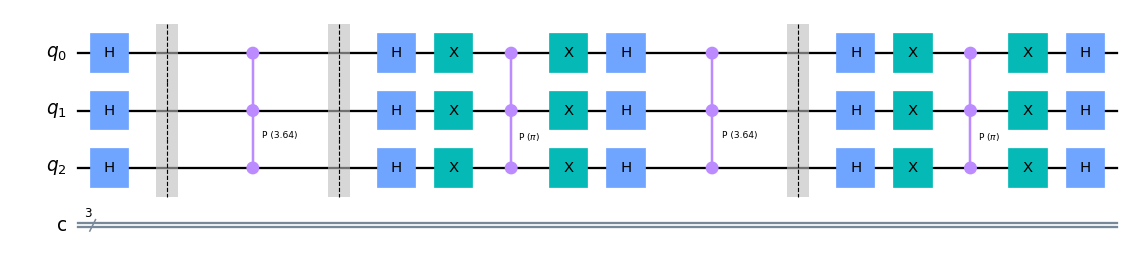

Probability Distribution of Psi after QC


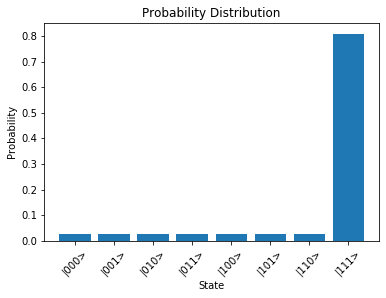

In [5]:
# Drawing Quantum Circuit
fig, ax = plt.subplots(figsize=(int(2*10), int(2*6)))  # Adjust the figsize as needed
qc.draw(output='mpl', ax=ax, scale=1.0)
plt.show()


print('Probability Distribution of Psi after QC')
HistPsi(qc)

# Qiskit Results

In [6]:
psi1 = psi_list[0] # psi after the first iteration
psi2 = psi_list[1] # psi after the second iteration

marked1 = psi1[-1] # Marked state after the first iteration
marked2 = psi2[-1] # Marked State After the second iteration

prob1 = np.abs(psi1)**2
prob2 = np.abs(psi2)**2

print('Quantum Circuit Computation for epsilon = ' + str(epsilon))
print('marked0 = ', 1/np.sqrt(2**num_qubits))
print('marked1 = ', marked1)
print('marked2 = ', marked2)

Quantum Circuit Computation for epsilon = 0.5
marked0 =  0.35355339059327373
marked1 =  (-0.85142-0.12713j)
marked2 =  (0.84298+0.31566j)


# Geometry Results

In [7]:
print('marked0 = ', 1/np.sqrt(2**num_qubits))

for i in range(1,3):
    print('marked'+ str(i)+' = ',Grovers(num_qubits, np.pi + epsilon, iters = i))

marked0 =  0.35355339059327373
marked1 =  (0.8514226512496336+0.12712689353289178j)
marked2 =  (0.8429790422543981+0.3156612264893468j)


Ok! So it seems like we have a match for the results of the marked amplitude between Quantum Circuit and Geormatrical Interpretations. The only apparent discrepancy here is 'marked1' between both results differ by a global phase, but that's ok because the presence of a global phase has no effect on the measurement/results of our wavefunction.

# Plotting Marked State Probability Curve and Visualizing $\epsilon_{50\%}$ ($\approx$ HWHM)

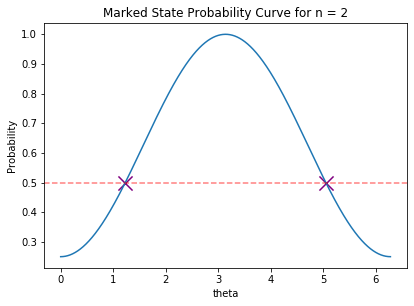

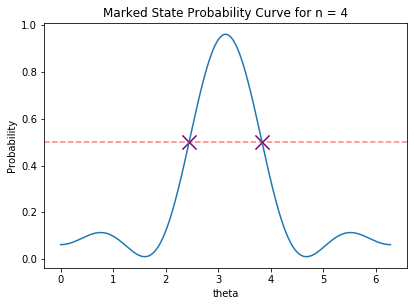

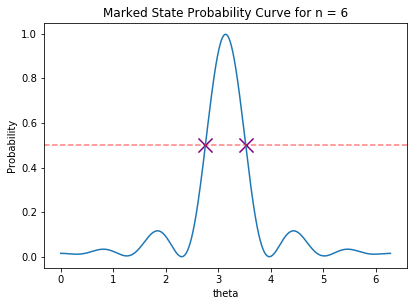

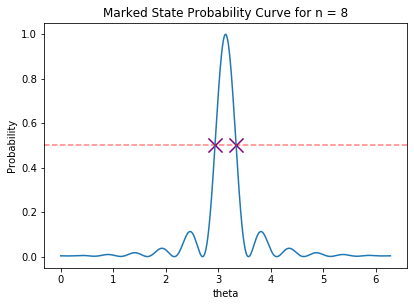

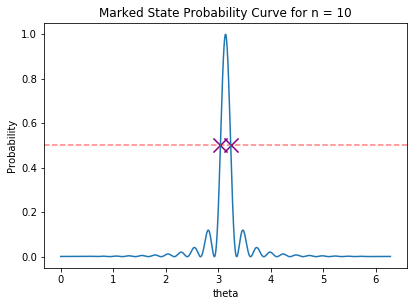

In [8]:
theta = np.linspace(0,2*np.pi,5000)

qubit_sizes = [2,4,6,8,10]

for q in qubit_sizes:
    psi = Grovers(q,theta)
    prob = np.abs(psi)**2
    eps50 = EpsFunc(theta,prob, 0.5)

    plt.figure(figsize = (6.5,4.5))
    plt.title('Marked State Probability Curve for n = ' + str(q))
    plt.plot(theta, prob)
    plt.xlabel('theta')
    plt.ylabel('Probability')
    plt.axhline(0.5, c = 'r', linestyle = '--', alpha = 0.5)
    plt.scatter(np.pi-eps50, 0.5, s = 200, marker = 'x', color = 'purple')
    plt.scatter(np.pi+eps50, 0.5, s = 200, marker = 'x', color = 'purple')
    plt.show()

# Calculating $\epsilon_{50\%}$, $\epsilon_{70\%}$, and $\epsilon_{90\%}$ for Different Qubit Sizes

In [9]:
# Epsilon50 (Width Calculation)

num_qubits_arr = np.arange(2,15,1)
N = len(num_qubits_arr)

eps50_arr = np.zeros(N)
eps65_arr = np.zeros(N)
eps80_arr = np.zeros(N)


Nt = 10000 # Number of theta slices
theta = np.linspace(0,2*np.pi,Nt)
for i in range(N):
    if i != 0:
        theta = np.linspace(np.pi - eps50, np.pi+eps50, Nt) # Adjusting the theta window for each consequtive scan
        
    num_qubits = num_qubits_arr[i]
    marked_amp = Grovers(num_qubits, theta)
    prob = abs(marked_amp)**2
    
    # Calculating and Recording Eps50
    eps50 = EpsFunc(theta,prob, 0.5)
    eps50_arr[i] = eps50
    
    # Calculating and Recording Eps70
    eps65 = EpsFunc(theta,prob,0.65)
    eps65_arr[i] = eps65
    
    # Calculating and Recording Eps90
    eps80 = EpsFunc(theta,prob,0.80)
    eps80_arr[i] = eps80
    # Status Update

    print(np.round(100*(i+1)/N,1), '%')

7.7 %
15.4 %
23.1 %
30.8 %
38.5 %
46.2 %
53.8 %
61.5 %
69.2 %
76.9 %
84.6 %
92.3 %
100.0 %


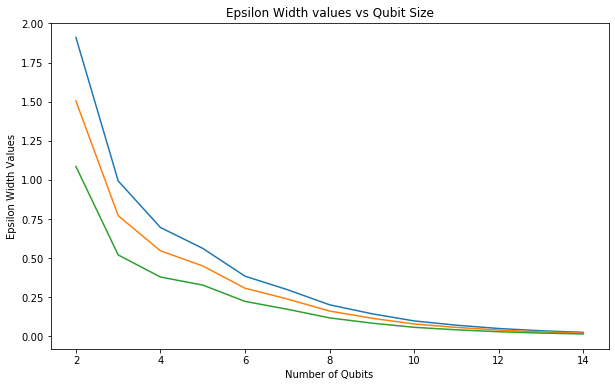

In [10]:
plt.figure(figsize = (10,6))

plt.title('Epsilon Width values vs Qubit Size')
plt.plot(num_qubits_arr, eps50_arr)
plt.plot(num_qubits_arr, eps65_arr)
plt.plot(num_qubits_arr, eps80_arr)

plt.xlabel('Number of Qubits')
plt.ylabel('Epsilon Width Values')

plt.show()

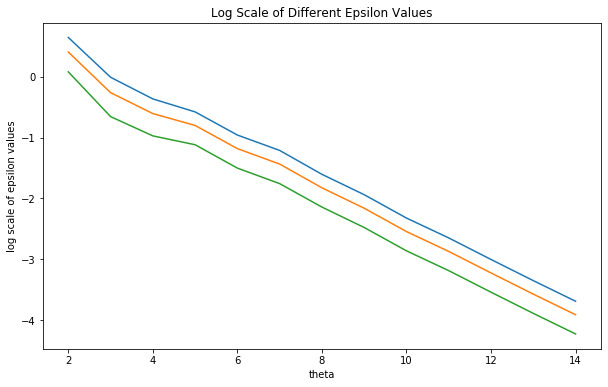

In [11]:
# Representing Epsilon Width values on a log scale

X50 = np.log(eps50_arr)
X65 = np.log(eps65_arr)
X80 = np.log(eps80_arr)


plt.figure(figsize =(10,6))
plt.title('Log Scale of Different Epsilon Values')
plt.plot(num_qubits_arr, X50, label = 'log(eps_50)')
plt.plot(num_qubits_arr, X65, label = 'log(eps_65)')
plt.plot(num_qubits_arr, X80, label = 'log(eps_80)')
plt.xlabel('theta')
plt.ylabel('log scale of epsilon values')
plt.show()

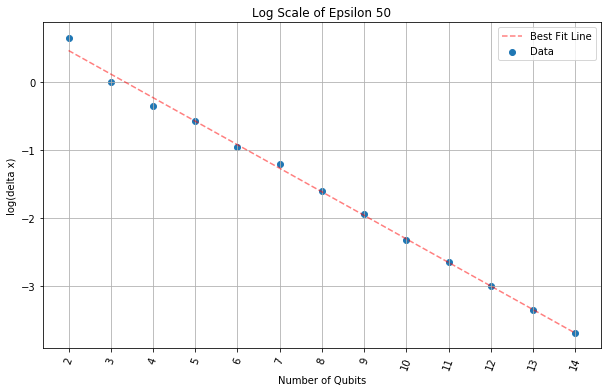

In [12]:
m,b = np.polyfit(num_qubits_arr, X50, 1)
X50_fit = num_qubits_arr*m + b

plt.figure(figsize = (10,6))
plt.title('Log Scale of Epsilon 50')
plt.scatter(num_qubits_arr, X50, label ='Data')
plt.plot(num_qubits_arr, X50_fit, color = 'red', alpha = 0.5, linestyle = '--', label = 'Best Fit Line')
plt.xlabel('Number of Qubits')
plt.ylabel('log(delta x)')
plt.xticks(num_qubits_arr, rotation ='70')
plt.yticks(np.arange(int(min(X50)), int(max(X50))+1,1  ))
plt.legend(loc = 'upper right')
plt.grid()
plt.show()